In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [8]:
def info_graph(*file):
    
    colorNum = 0
    for i in file:
        colorNum += 1
        # DATA 
        df = pd.read_csv(i)

        # FORMATTING THE DATE
        value = 0
        try:
            datetime.strptime(df['Date'][0], '%Y-%m-%d')
            value = 0
        except ValueError:
            value = 1
        if value == 1:
            df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
        else:
            df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
        df.index = df['Date']

        # SORTING
        data = df.sort_index(ascending=True, axis=0)
        pd.options.mode.chained_assignment = None

        new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
        for i in range(0,len(data)):
            new_data['Date'][i] = data['Date'][i]
            new_data['Close'][i] = data['Close'][i]

        # INDEXING
        new_data.index = new_data.Date
        new_data.drop('Date', axis=1, inplace=True)

        # # DIVIDING THE DATA AND SCALING
        dataset = new_data.values
        number = int(0.8*len(data))
        train = dataset[0:number,:]
        test = dataset[number:,:]

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(dataset)

        x_train, y_train = [], []
        for i in range(60,len(train)):
            x_train.append(scaled_data[i-60:i,0])
            y_train.append(scaled_data[i,0])
        x_train, y_train = np.array(x_train), np.array(y_train)

        x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

        # LSTM MODEL
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

        # PREDICTION
        inputs = new_data[len(new_data) - len(test) - 60:].values
        inputs = inputs.reshape(-1,1)
        inputs  = scaler.transform(inputs)

        X_test = []
        for i in range(60,inputs.shape[0]):
            X_test.append(inputs[i-60:i,0])
        X_test = np.array(X_test)

        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
        closing_price = model.predict(X_test)
        closing_price = scaler.inverse_transform(closing_price)

        # PREDICTIONS
        train = new_data[:number]
        test = new_data[number:]
        test['Predictions'] = closing_price

        # PLOTTING THE GRAPH
        test['Close'].plot(label = f'COMPANY {colorNum}: TESTING-DATA')
        test['Predictions'].plot(label = f'COMPANY {colorNum}: PREDICTION')

928/928 - 60s - loss: 0.0012 - 60s/epoch - 64ms/step
8/8 [==============================] - 5s 37ms/step
1872/1872 - 115s - loss: 5.8847e-04 - 115s/epoch - 62ms/step
16/16 [==============================] - 6s 42ms/step
4463/4463 - 227s - loss: 2.4213e-04 - 227s/epoch - 51ms/step
36/36 [==============================] - 4s 39ms/step
6388/6388 - 310s - loss: 1.4613e-04 - 310s/epoch - 49ms/step
51/51 [==============================] - 6s 40ms/step
8292/8292 - 385s - loss: 1.4101e-05 - 385s/epoch - 46ms/step
66/66 [==============================] - 5s 40ms/step


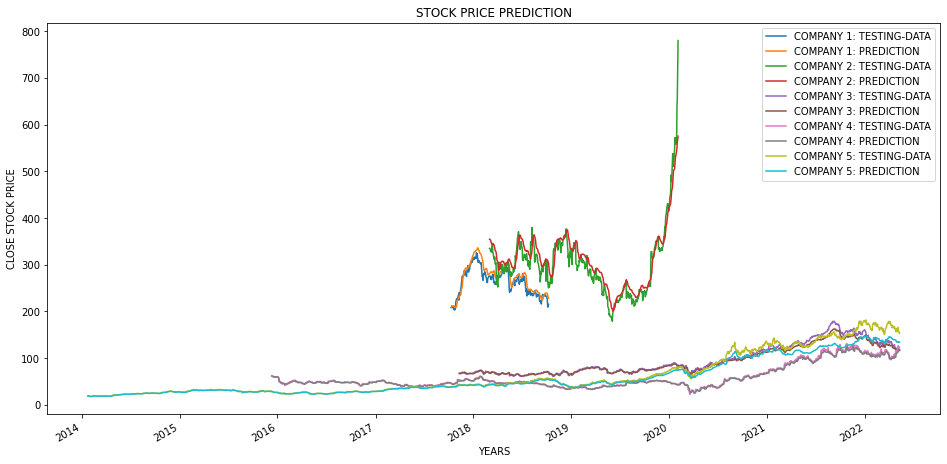

In [9]:
plt.figure(figsize=(16,8))
info_graph('NSE-TATAGLOBAL11.csv','TSLA.csv','A.csv', 'AN.csv', 'AAPL.csv')
plt.title('STOCK PRICE PREDICTION')
plt.xlabel('YEARS')
plt.ylabel('CLOSE STOCK PRICE')
plt.legend()